In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import pandas as pd

In [3]:
#df = pd.read_csv(r"C:\Users\Lim Jia Hui\Downloads\icml_face_data.csv\icml_face_data.csv")
#print(df.iloc[0,1])
#for i in range(len(df)):
#    if df.iloc[i,1] != 'Training':
#       break
#print(f'Training data length: {i} Test data length: {len(df)-i}')
#traindf = df[df[' Usage'] == 'Training'].drop(' Usage', axis=1)
#testdf = df[df[' Usage'] != 'Training'].drop(' Usage', axis=1)

#print(traindf.head())

#traindf.to_csv(r"C:\Users\Lim Jia Hui\Desktop\VsCode Test\data\fer2013\train.csv", index=False)
#testdf.to_csv(r"C:\Users\Lim Jia Hui\Desktop\VsCode Test\data\fer2013\test.csv", index=False)

Training
Training data length: 28709 Test data length: 7178
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Dataset

In [2]:
from torch.utils.data import Dataset
#Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.labels =self.data.iloc[:, 0]
        self.pixels = self.data.iloc[:, 1:].to_numpy()
        self.transform = torchvision.transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.transform(np.transpose(np.fromstring(self.pixels[idx][0], sep = ' ', dtype= int).reshape(48, 48)).reshape(1,48,48)).float().reshape(1,48,48)
        image /= 255
        label = self.labels[idx]
        return image, label
    


Happy       7215
Neutral     4965
Sad         4830
Fear        4097
Angry       3995
Surprise    3171
Disgust      436
Name: emotion, dtype: int64


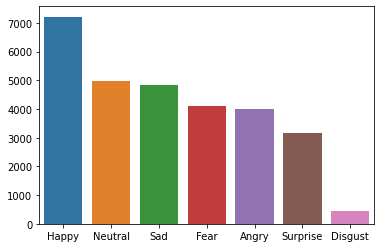

In [3]:
#Frequency of different emotions inside train dataset
traindf = pd.read_csv(r"C:\Users\Lim Jia Hui\Desktop\VsCode Test\data\fer2013\train.csv")

print(traindf['emotion'].value_counts(sort=True).rename(index={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}))

sns.barplot(x=traindf['emotion'].value_counts(sort=True).rename(index={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}).index, y=traindf['emotion'].value_counts(sort=True).values)
plt.show()


In [4]:
from torch.utils.data import DataLoader

data_train = CustomDataset(csv_file = r"C:\Users\Lim Jia Hui\Desktop\VsCode Test\data\fer2013\train.csv")
train_batches = DataLoader(data_train, batch_size=64, shuffle=True)

data_test = CustomDataset(csv_file = r"C:\Users\Lim Jia Hui\Desktop\VsCode Test\data\fer2013\test.csv")
test_batches = DataLoader(data_test, batch_size=64, shuffle=False)

In [25]:
data_train.__getitem__(idx=0)[0][0]


tensor([[0.2745, 0.3137, 0.3216,  ..., 0.2039, 0.1686, 0.1608],
        [0.2549, 0.2392, 0.2275,  ..., 0.2196, 0.2039, 0.1725],
        [0.1961, 0.1686, 0.2118,  ..., 0.1922, 0.2196, 0.1843],
        ...,
        [0.3569, 0.2549, 0.1647,  ..., 0.2824, 0.2196, 0.1686],
        [0.3020, 0.3216, 0.3098,  ..., 0.4118, 0.2745, 0.1804],
        [0.3020, 0.2824, 0.3294,  ..., 0.4157, 0.4275, 0.3216]])

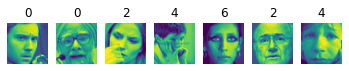

In [5]:
#Visualisation of first 7 images in train dataset
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow((data_train.__getitem__(idx=i)[0].view(48,48)))
    ax[i].set_title(data_train.__getitem__(idx=i)[1])
    ax[i].axis('off')

## Modeling

In [2]:
#A ResNet-based model for facial expression recognition
import torch as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
import torchvision
import torch.nn as nn
from torch.nn.functional import relu
from torch.nn.functional import max_pool2d
from torch.nn.functional import softmax
from torch.nn.functional import cross_entropy
from typing import Optional

import time

start_time = time.time()

device = 'cuda'

evaliters = 100

er_patience = 3

epochs = 15

torch.manual_seed(1337)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample: Optional[nn.Module] = None):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(self.inplanes, self.inplanes, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.layer1 = self.make_layer(BasicBlock, 64, 2)
        self.layer2 = self.make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 256, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*1*1, 7) # 128 convolutions of 1x1 pixels, 7 classes
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        if isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        if isinstance(module, nn.BatchNorm2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            torch.nn.init.zeros_(module.bias)

    def forward(self, x, label=None):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = relu(x)
        x = max_pool2d(x,2,2)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        logit = self.fc1(x)
        x = softmax(logit, dim=1)
        if label is not None:
            loss = cross_entropy(logit, label)
            return logit, loss, x
        else:
            return logit, x


    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

model = ConvNet()

model.to(device)




ConvNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [7]:
#Train the model
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.0001)

trainlosslist = []
testlosslist = []

def eval(image,label,type):
    image = image.to(device)
    label = label.to(device)
    loss = model(image, label)[1]
    if type == 'train':
        trainevallosses[traincounter] = loss.item()
    elif type == 'test':
        testevallosses[testcounter] = loss.item()

for epoch in range(epochs):
    trainevallosses = torch.zeros(100)
    testevallosses = torch.zeros(100)
    for image, label, in train_batches:
        image = image.to(device)
        label = label.to(device)
        loss = model(image, label)[1]
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        traincounter = 0
        for trainevalimage, trainevallabel in torch.utils.data.DataLoader(data_train,batch_size=64,shuffle=False):
            if traincounter >= 100:
                break
            eval(trainevalimage,trainevallabel,'train')
            traincounter += 1

        testcounter = 0
        for testevalimage, testevallabel in torch.utils.data.DataLoader(data_test,batch_size=64,shuffle=False):
            if testcounter >= 100:
                break
            eval(testevalimage,testevallabel,'test')
            testcounter += 1
            
        trainlosslist.append(trainevallosses.mean().item())
        testlosslist.append(testevallosses.mean().item())

    print(f"epoch {epoch}: train loss {trainevallosses.mean()} test loss {testevallosses.mean()} time {(time.time() - start_time)//60:.0f}m {(time.time() - start_time) % 60:.2f}s")
    model.train()


    if testlosslist[-1] == min(testlosslist):
        torch.save(model.state_dict(), r"C:\Users\Lim Jia Hui\Downloads\ferweights.txt")
        print('saved best model')

    if testlosslist.index(min(testlosslist)) + 1 <= len(testlosslist) - er_patience:
        print('early stopping')
        break


epoch 0: train loss 1.6345925331115723 test loss 1.6328370571136475 time 0m 38.56s
saved best model
epoch 1: train loss 1.2914732694625854 test loss 1.3020199537277222 time 1m 2.08s
saved best model
epoch 2: train loss 1.2055678367614746 test loss 1.245739459991455 time 1m 28.80s
saved best model
epoch 3: train loss 1.1168138980865479 test loss 1.1725564002990723 time 1m 58.74s
saved best model
epoch 4: train loss 1.0348070859909058 test loss 1.1343122720718384 time 2m 30.60s
saved best model
epoch 5: train loss 1.0015023946762085 test loss 1.1478087902069092 time 3m 0.43s
epoch 6: train loss 0.8995930552482605 test loss 1.1193509101867676 time 3m 30.84s
saved best model
epoch 7: train loss 0.8169887661933899 test loss 1.1279587745666504 time 4m 2.89s
epoch 8: train loss 0.7545665502548218 test loss 1.153904914855957 time 4m 33.89s
epoch 9: train loss 0.6416862607002258 test loss 1.1855870485305786 time 5m 6.17s
early stopping


## Real-Time Face detection and Emotion Recognition

In [4]:
from facenet_pytorch import MTCNN

import cv2

model.load_state_dict(torch.load(r"C:\Users\Lim Jia Hui\Downloads\ferweights.txt"))

model.eval()
mtcnn = MTCNN()

cap = cv2.VideoCapture(0)

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

while True:
    ret, frame = cap.read()

    face = mtcnn.detect(frame)

    if face[0] is not None:

        intface = [int(loc) for loc in face[0][0]]
        cv2.rectangle(frame, (intface[0], intface[1]), (intface[2], intface[3]), (0, 255, 0), 2)
        croppedface = frame[intface[1]:intface[3], intface[0]:intface[2]]

        croppedface = cv2.resize(croppedface, (48, 48))
        croppedgrayface = torch.from_numpy(cv2.cvtColor(croppedface, cv2.COLOR_BGR2GRAY)).view(1, 1, 48, 48).float()
        croppedgrayface /= 255

        with torch.no_grad():
            predidx = torch.argmax(model(croppedgrayface.to(device))[1],dim=1)



        cv2.putText(frame, emotions[predidx], (intface[2], intface[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    
    

    cv2.imshow('video', frame)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    

cap.release()
cv2.destroyAllWindows()
model.train()
print('window closed')

window closed


## Evaluation

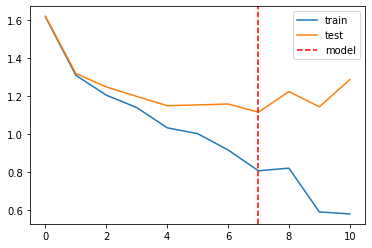

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(trainlosslist)),y=trainlosslist,label='train')
sns.lineplot(x=range(len(trainlosslist)),y=testlosslist,label='test')
plt.axvline(x=testlosslist.index(min(testlosslist)),color='red',linestyle = '--', label='model')
plt.legend(loc='upper right')
plt.show()

In [12]:
from torchinfo import summary

summary(model,(1,1,48,48))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 44, 44]           1,664
├─Conv2d: 1-2                            [1, 64, 40, 40]           102,464
├─BatchNorm2d: 1-3                       [1, 64, 40, 40]           128
├─Sequential: 1-4                        [1, 64, 20, 20]           --
│    └─BasicBlock: 2-1                   [1, 64, 20, 20]           --
│    │    └─Conv2d: 3-1                  [1, 64, 20, 20]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 20, 20]           128
│    │    └─ReLU: 3-3                    [1, 64, 20, 20]           --
│    │    └─Conv2d: 3-4                  [1, 64, 20, 20]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 20, 20]           128
│    │    └─ReLU: 3-6                    [1, 64, 20, 20]           --
│    └─BasicBlock: 2-2                   [1, 64, 20, 20]          

In [8]:
#evaluations for every run differ even when the seed is set(i have no idea why)

model.load_state_dict(torch.load(r"C:\Users\Lim Jia Hui\Downloads\ferweights.txt"))
predictions = []
model.eval()
with torch.no_grad():
    for image, label in data_test:
        image = image.view(1,1,48,48).to('cuda')
        output = model(image.to('cuda'))[0]
        predictions.append(output.argmax().item())
model.train()
print(predictions[:5])

[6, 0, 0, 4, 3]


In [9]:
from sklearn.metrics import accuracy_score

print(accuracy_score(data_test.labels,predictions))

0.5908331011423795


In [10]:
from sklearn.metrics import classification_report
emotionsidx = enumerate(('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'))
for emo in emotionsidx:
    print(emo)
print(classification_report(data_test.labels,predictions))

(0, 'Angry')
(1, 'Disgust')
(2, 'Fear')
(3, 'Happy')
(4, 'Sad')
(5, 'Surprise')
(6, 'Neutral')
              precision    recall  f1-score   support

           0       0.44      0.61      0.51       958
           1       0.55      0.49      0.52       111
           2       0.46      0.35      0.40      1024
           3       0.89      0.74      0.80      1774
           4       0.46      0.52      0.49      1247
           5       0.77      0.73      0.75       831
           6       0.53      0.56      0.55      1233

    accuracy                           0.59      7178
   macro avg       0.58      0.57      0.57      7178
weighted avg       0.61      0.59      0.60      7178

